Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 06/22/23\
Last modified: 07/06/23\
DSI

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator, DeeplTranslator
import jellyfish
import recordlinkage
from recordlinkage.datasets import load_febrl4

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [218]:
# Helper functions

def cargo_grouping(df, group, other_cols, sort, asc_bool, new_name = None):
    """
    Create grouped dataframes for charts

    Inputs:
        df(DataFrame): dataset to be used
        group(lst): list of columns to group by
        other_cols(lst): list of columns that are going to be aggregated
        sortby(lst): list of columns to sort dataframe by. If new_name is not
            empty then the new column names should be used.
        new_name(lst): optional paramater with list of new names for grouped
            dataframe. Default is "None".

    Return(DataFrame): grouped dataframe for charts
    """
    cols = other_cols[:]
    cols.extend(group)
    df_g = df.loc[:, cols].groupby(group)

    if new_name is not None:
        col_dict = {}
        for i, col in enumerate(other_cols):
            col_dict[col] = new_name[i]
        grouped = df_g.sum().reset_index().rename(columns = col_dict) # PENDING: change this later to include any kind of aggregation
    else:
        grouped = df_g.sum().reset_index()
    
    if sort is None:
        return grouped
    else:
        return grouped.sort_values(by=sort, ascending=asc_bool)

    
def plot_line(x_axis, y_axis, line_labels, graph_title, x_label, y_label):
    """
    Plot line chart

    Inputs:
        x_axis (array or Series): values for the x axis of the plot
        y_axis (lst): list of arrays or series with values for y axis of the
            plot. If list has n elements then chart will plot n lines. 
        line_labels (lst): list of strings with label names for each line
            respectively
        graph_title (str): title for line chart
        x_label (str): title for the x axis
        y_label (str): title for the y axis
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, column in enumerate(y_axis):
        ax.plot(x_axis, column, label = line_labels[i])
        for x, y in zip(x_axis, column):
            ax.annotate(f'{int(y)}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()


def plot_crops(crop, df_1, df_2):
    """
    Plot line chart with crops exports for one company and the total BSGI
        exports

    Inputs:
        crop (str): name of crop that we want to plot
        df_1 (DataFrame): dataset to use for first line
        df_2 (DataFrame): dataset to use for second line
    """

    crop_kernel = df_1.loc[df_1.loc[:, crop] == True]
    kernel_g = cargo_grouping(crop_kernel, ["year", "month"], ["weight_ton"], ["year", "month"], True)
    kernel_g["date"] = kernel_g["month"].astype(str) + "/" + kernel_g["year"].astype(str)

    # BSGI data
    crop_bsgi = df_2.loc[df_2.loc[:, "product_std"] == crop]
    outbound_g = cargo_grouping(crop_bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True)
    outbound_g["date"] = outbound_g["month"].astype(str) + "/" + outbound_g["year"].astype(str)

    # Plot together
    final = kernel_g.merge(outbound_g, on="date", suffixes=("_kernel", "_bsgi"))

    plot_line(final["date"], [final["weight_ton_kernel"], final["weight_ton_bsgi"]], ["Kernel", "Black Sea Grain Initiative"], "BSGI and Kernel volume of {} exports".format(crop), "Export date (m-yy)", "{} exported (tons)".format(crop))


def translate_column(df, column, translator, source="uk", target="en"):
    """
    Translate string column faster with Google or Deepl translator.

    Inputs:
        df (DataFrame): dataset
        column (str): name of column to translate. Column values should be
            strings
        translator (str): translator to use. Can be either 'google' or 'deepl'
        source (str): code of language to translate. Default is 'uk' (Ukrainian)
        target (str): target of language to translate. Default is 'en' (English)

    Return: None. Adds new column to passed dataframe.
    """

    # We create list with unique column values so we only translate neccesary
    # number of values
    unique_val = df[column].unique()

    # Translate with Google Translate
    d = {}
    if translator == "google":
        for val in unique_val:
            d[val] = GoogleTranslator(source=source, target=target).translate(val)
        df[column.lower() + "_gt"] = df[column].apply(lambda x: d[x])
    elif translator == "deepl":
        for val in unique_val:
            d[val] = DeeplTranslator(api_key="38e53e96-d3f6-559d-f08b-163d92b711a8:fx", source=source, target=target, use_free_api=True).translate(val)
        df[column.lower() + "_deepl"] = df[column].apply(lambda x: d[x])
    else:
        return "Wrong translator name. Use 'google' or 'deepl'."
    

def find_matches(dfA, dfB, exact_vars= None, string_vars=None, block_vars=None):
    """
    Find most possible matches between two datasets based on different columns

    Inputs:
        dfA (DataFrame): first dataset to match
        dfB (DataFrame): second dataset to match
        exact_vars (lst): list of strings with variables names we want to match
            exactly. If empty, it's set to "None" by default
        string_vars (lst): list of strings with variables names we want to match
            by the Jaro Winkler distance rule. If empty, it's set to "None" by
            default
        block_vars (lst): list of strings with blocking variables names. If
            empty, it's set to "None" by default.

    Returns (DataFrame): dataframe with matches from both datasets. Matches are
        not necessarily unique.
    """

    indexer = recordlinkage.Index()
    for block in block_vars:
        indexer.block(block)
    candidate_links = indexer.index(dfA, dfB)

    # Comparison step
    compare_cl = recordlinkage.Compare()

    for exact in exact_vars:
        compare_cl.exact(exact, exact, label=exact)
    for string in string_vars:
        compare_cl.string(string, string, method="jarowinkler", threshold=0.9, label=string)

    features = compare_cl.compute(candidate_links, dfA, dfB)

    # Classification step
    matches = features[features.sum(axis=1) > 1]
    print("Number of matches: ",len(matches))
    
    return matches

In [4]:
## RENAME VARIABLES FROM THE BEGGINING

kernel = pd.read_csv("../data/import genius/kernel_10000.csv", parse_dates=["EXPORT DATE"])

print("Columns: ", kernel.dtypes)

# All custom office values are NaN
print("Custom office values: ", kernel["CUSTOMS VALUE"].dropna().values)

# We still have to get data from 2011 to 2021
print("Min year: ",kernel["EXPORT DATE"].dt.year.min(skipna=True))
print("Max year: ", kernel["EXPORT DATE"].dt.year.max(skipna=True))

kernel.head()

Columns:  PRODUCT                                     object
HS CODE                                      int64
CONSIGNEE                                   object
CONSIGNEE ADDRESS                          float64
SHIPPER                                     object
SHIPPER ADDRESS                            float64
EXPORT DATE                         datetime64[ns]
QUANTITY                                   float64
WEIGHT (KG)                                float64
INVOICE PRICE (UAH)                        float64
TOTAL INVOICE VALUE (USD)                  float64
INVOICE PRICE IN KILOGRAMS (USD)           float64
ITEM UNIT                                  float64
ITEM NUMBER                                float64
CUSTOMS VALUE                              float64
CUSTOMS OFFICE CODE                          int64
COUNTRY OF ORIGIN                          float64
DESTINATION COUNTRY                         object
PLACE OF DELIVERY                          float64
DELIVERY TERMS       

,PRODUCT,HS CODE,CONSIGNEE,CONSIGNEE ADDRESS,SHIPPER,SHIPPER ADDRESS,EXPORT DATE,QUANTITY,WEIGHT (KG),INVOICE PRICE (UAH),...,CUSTOMS VALUE,CUSTOMS OFFICE CODE,COUNTRY OF ORIGIN,DESTINATION COUNTRY,PLACE OF DELIVERY,DELIVERY TERMS,DECLARATION NO.,CURRENCY RATIO,SENDER CODE,BANK NAME
0,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,NaN,0,NaN,ОМАН,NaN,FCA UA ПОЛТАВА,4138,NaN,31454383,NaN
1,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,NaN,0,NaN,ОМАН,NaN,FCA UA ПОЛТАВА,4141,NaN,31454383,NaN
2,СОЛІ ТА ГІДРОКСИДИ АМОНІЮ ЧЕТВЕРТИННІ; ЛЕЦИТИН...,2923200000,NATEEO SRL VIA DELL INNOVAZIONE N 1 36043 CAMI...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23700.0000,4408200.0000,...,NaN,0,NaN,ІТАЛІЯ,NaN,DAP IT CAMISANO VICENTINO V,4147,NaN,31454383,NaN
3,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,24380.0000,1025550.0000,...,NaN,0,NaN,СЕНЕГАЛ,NaN,FAS RO CONSTANTA,4148,NaN,31454383,NaN
4,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23950.0000,754425.0000,...,NaN,0,NaN,ОМАН,NaN,FCA UA ПОЛТАВА,4118,NaN,31454383,NaN


In [5]:
# EXPORTS TIME SERIES
# We first have to translate the "PRODUCT" column with the deep_translator API
kernel_c = kernel.copy()
translate_column(kernel_c, "PRODUCT", "google")
translate_column(kernel_c, "PRODUCT", "deepl")


In [6]:
kernel_c["same_translation"] = kernel_c["product_gt"] == kernel_c["product_deepl"]

# Check how similar were the translations
print("How many rows were translated the same? ", sum(kernel_c["same_translation"]))
print("Different translations:\n", kernel_c[["product_gt", "product_deepl", "same_translation"]].head())

How many rows were translated the same?  2
Different translations:
                                           product_gt  \
0  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   
1  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   
2  QUATERNARY AMMONIUM SALTS AND HYDROXIDES; LECI...   
3  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   
4  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   

                                       product_deepl  same_translation  
0  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  
1  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  
2  QUATERNARY AMMONIUM SALTS AND HYDROXIDES; LECI...             False  
3  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  
4  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  


Kernel exports:
     year  month   weight_ton     date
0   2021      2   91121.4299   2/2021
1   2021      3  478853.0751   3/2021
2   2021      4  452908.6948   4/2021
3   2021      5  470043.8489   5/2021
4   2021      6  309766.5866   6/2021
5   2021      7  255740.5989   7/2021
6   2021      8  484305.1458   8/2021
7   2021      9 1285166.6159   9/2021
8   2021     10  883951.6273  10/2021
9   2021     11  658564.7871  11/2021
10  2021     12  645676.1746  12/2021
11  2022      1  898310.1806   1/2022
12  2022      2  633372.8506   2/2022
13  2022      3  114976.3740   3/2022
14  2022      4   10286.2381   4/2022
15  2022      5   35388.4236   5/2022
16  2022      6   77129.8371   6/2022
17  2022      7   92061.1637   7/2022
18  2022      8  188783.1263   8/2022
19  2022      9  251852.2948   9/2022
20  2022     10  437507.0604  10/2022
21  2022     11  287577.1598  11/2022
22  2022     12  425072.9370  12/2022
23  2023      1  298909.7725   1/2023
24  2023      2  197489.0525   2/

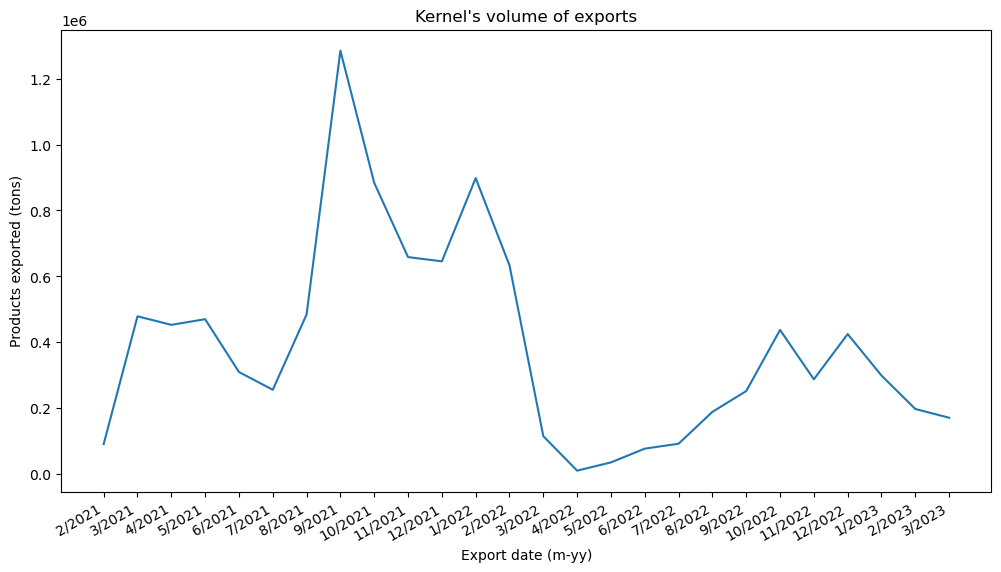

In [8]:
kernel_c["year"] = kernel_c["EXPORT DATE"].dt.year
kernel_c["month"] = kernel_c["EXPORT DATE"].dt.month
kernel_c["weight_ton"] = kernel_c["WEIGHT (KG)"] / 1000

kernel_g = kernel_c[["year", "month", "weight_ton"]].groupby(["year", "month"])
kernel_g = kernel_g.sum().reset_index()
kernel_g.sort_values(by=["year", "month"], ascending=False)

kernel_g["date"] = kernel_g["month"].astype(str) + "/" + kernel_g["year"].astype(str)
kernel_g

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(kernel_g["date"] , kernel_g["weight_ton"])
# ax.ticklabel_format(useOffset=False, style='plain')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.title("Kernel's volume of exports")
plt.xlabel("Export date (m-yy)")
plt.ylabel("Products exported (tons)")

Text(0, 0.5, 'Products exported (tons)')

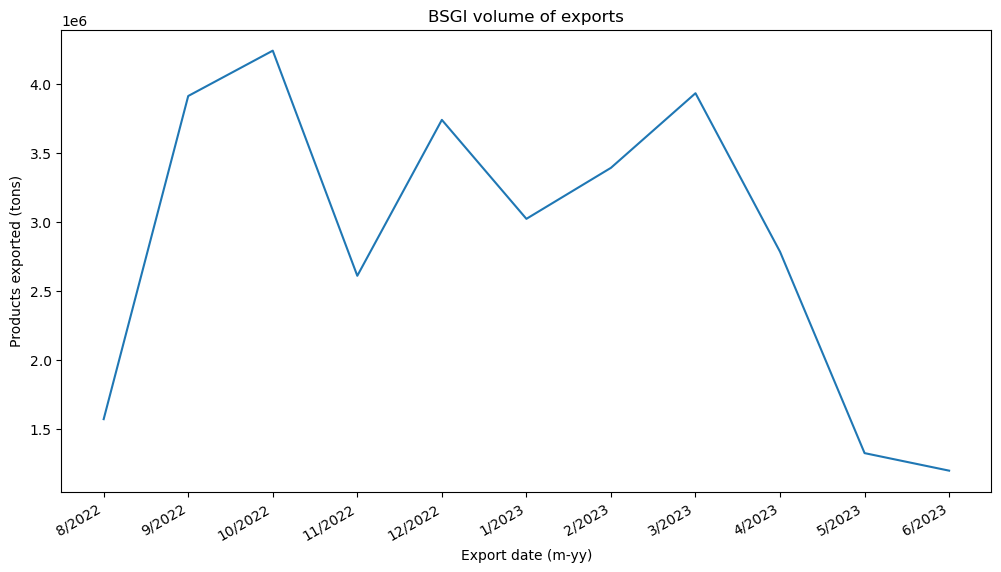

In [9]:
# Compare Kernel's exports with overall exports in the Black Sea ports from Black Sea Grain Initiative

outbound = pd.read_csv("../data/bsgi_outbound_shipments.csv", thousands=",", parse_dates=["Departure date"])

outbound["year"] = outbound["Departure date"].dt.year
outbound["month"] = outbound["Departure date"].dt.month
outbound["weight_ton"] = outbound["Metric tons"]

cargo_grouping(outbound, group, other_cols, sort, asc_bool, new_name = None)

# outbound_g = outbound[["year", "month", "weight_ton"]].groupby(["year", "month"])
# outbound_g = outbound_g.sum().reset_index()
# outbound_g.sort_values(by=["year", "month"], ascending=False)

# outbound_g["date"] = outbound_g["month"].astype(str) + "/" + outbound_g["year"].astype(str)
# outbound_g

# fig, ax = plt.subplots(figsize=(12, 6))

# ax.plot(outbound_g["date"] , outbound_g["weight_ton"])

# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# plt.title("BSGI volume of exports")
# plt.xlabel("Export date (m-yy)")
# plt.ylabel("Products exported (tons)")


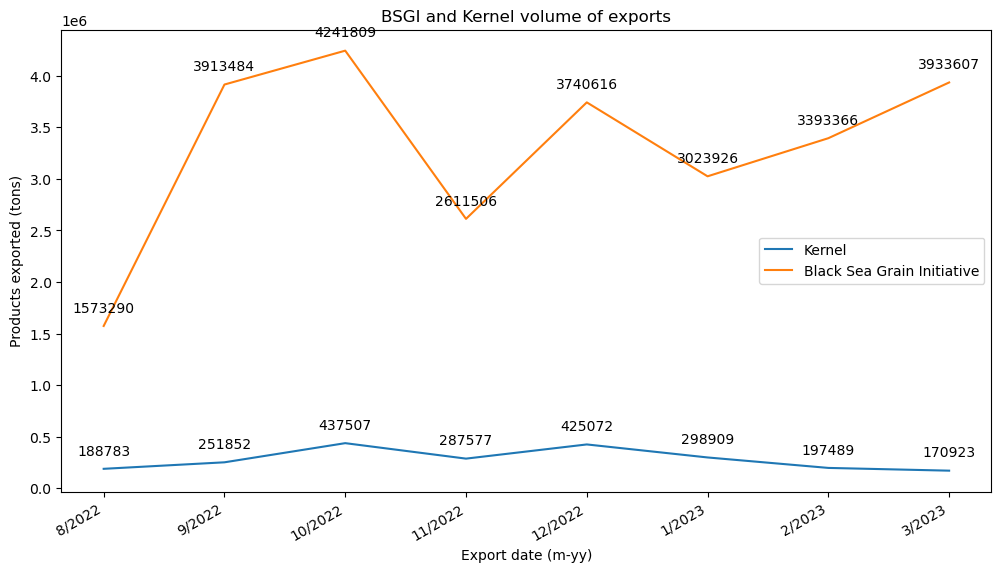

In [10]:
# Plot together
final = kernel_g.merge(outbound_g, on="date", suffixes=("_kernel", "_bsgi"))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(final["date"] , final["weight_ton_kernel"], label = "Kernel")
ax.plot(final["date"] , final["weight_ton_bsgi"], label = "Black Sea Grain Initiative")

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.title("BSGI and Kernel volume of exports")
plt.xlabel("Export date (m-yy)")
plt.ylabel("Products exported (tons)")
plt.legend()

# Annotate the lines
for x, y in zip(final["date"], final["weight_ton_kernel"]):
    ax.annotate(f'{int(y)}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

for x, y in zip(final["date"], final["weight_ton_bsgi"]):
    ax.annotate(f'{int(y)}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

In [11]:
# PLOT BY CROP

# First we see the possible product categories based on the BSGI dataset
products = outbound["Commodity"].unique()

products_val = ["corn", "soya", "sunflower", "wheat", "sunflower", "barley", "peas", "rapeseed", "sunflower", "vegetable", "soya", "canola", "rapeseed", "sunflower", "mixed", "wheat", "sugar beet"]

d = {}
for i, product in enumerate(products):
    d[product] = products_val[i]

outbound_c = outbound.copy()

outbound_c["product_std"] = outbound_c["Commodity"].apply(lambda x: d[x])
print("Outbound data:\n", outbound_c.head())

product_std = set(products_val)

# We create columns for each product
for product in product_std:
    kernel_c[product] = kernel_c["product_deepl"].apply(lambda x: True if product in x.lower() else False)

kernel_c


Outbound data:
        Status    #       Vessel name      IMO Departure port Country  \
0    Outbound  981       SSI AVENGER  9284544    Chornomorsk   Spain   
1  Outbound +  981       SSI AVENGER  9284544    Chornomorsk  France   
2    Outbound  980  SANTORINI ISLAND  9393618    Chornomorsk   Italy   
3    Outbound  979          EUROSTAR  9546203    Chornomorsk   China   
4    Outbound  978              DIAS  9248904          Odesa   China   

        Commodity  Metric tons Departure date Inspection cleared  \
0            Corn        18137     2023-06-14                NaN   
1      Soya beans        28963     2023-06-14                NaN   
2            Corn        45486     2023-06-14                NaN   
3  Sunflower meal        29188     2023-06-14                NaN   
4            Corn        66000     2023-06-14                NaN   

          Income group              Flag      World Bank region  \
0          high-income  Marshall Islands  Europe & Central Asia   
1       

,PRODUCT,HS CODE,CONSIGNEE,CONSIGNEE ADDRESS,SHIPPER,SHIPPER ADDRESS,EXPORT DATE,QUANTITY,WEIGHT (KG),INVOICE PRICE (UAH),...,vegetable,soya,corn,mixed,canola,wheat,rapeseed,sugar beet,barley,peas
0,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,False,False,False,False,False,False,False,False,False,False
1,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,False,False,False,False,False,False,False,False,False,False
2,СОЛІ ТА ГІДРОКСИДИ АМОНІЮ ЧЕТВЕРТИННІ; ЛЕЦИТИН...,2923200000,NATEEO SRL VIA DELL INNOVAZIONE N 1 36043 CAMI...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23700.0000,4408200.0000,...,False,False,False,False,False,False,False,False,False,False
3,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,24380.0000,1025550.0000,...,False,False,False,False,False,False,False,False,False,False
4,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23950.0000,754425.0000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,TSP TRADING SARL LEBANON JOUNIEH FREM BUILDING,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВ ШЕВЧЕНКА ТА...,NaN,2021-02-25,NaN,25191.9000,768900.6000,...,False,False,False,False,False,False,False,False,False,False
9996,"МАКУХА ТА ІНШІ ТВЕРДІ ВІДХОДИ І ЗАЛИШКИ, ОДЕРЖ...",2306300000,ООО СОЙТЭКС 220125 РЕСПУБЛИКА БЕЛАРУСЬ Г МИНСК...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,360350.0000,2948023.3500,...,True,False,False,False,False,False,False,False,False,False
9997,"МАКУХА ТА ІНШІ ТВЕРДІ ВІДХОДИ І ЗАЛИШКИ, ОДЕРЖ...",2306300000,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ АГРОГ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,243700.0000,2089118.2500,...,True,False,False,False,False,False,False,False,False,False
9998,"МАКУХА ТА ІНШІ ТВЕРДІ ВІДХОДИ І ЗАЛИШКИ, ОДЕРЖ...",2306300000,СЗАО АГРОЛИНК РЕСПУБЛИКА БЕЛАРУСЬ 213353 МOГИЛ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,179650.0000,1464866.1000,...,True,False,False,False,False,False,False,False,False,False


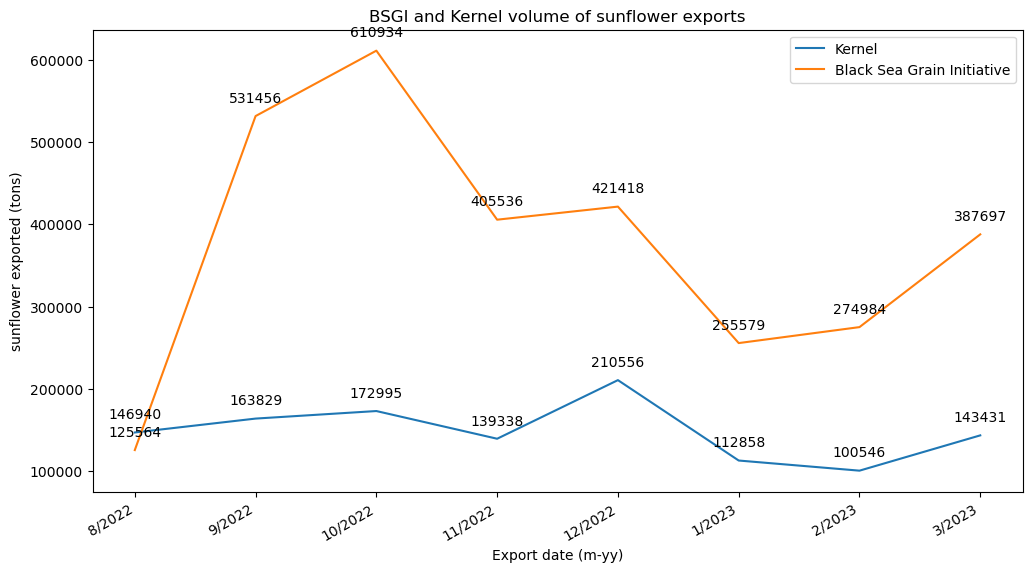

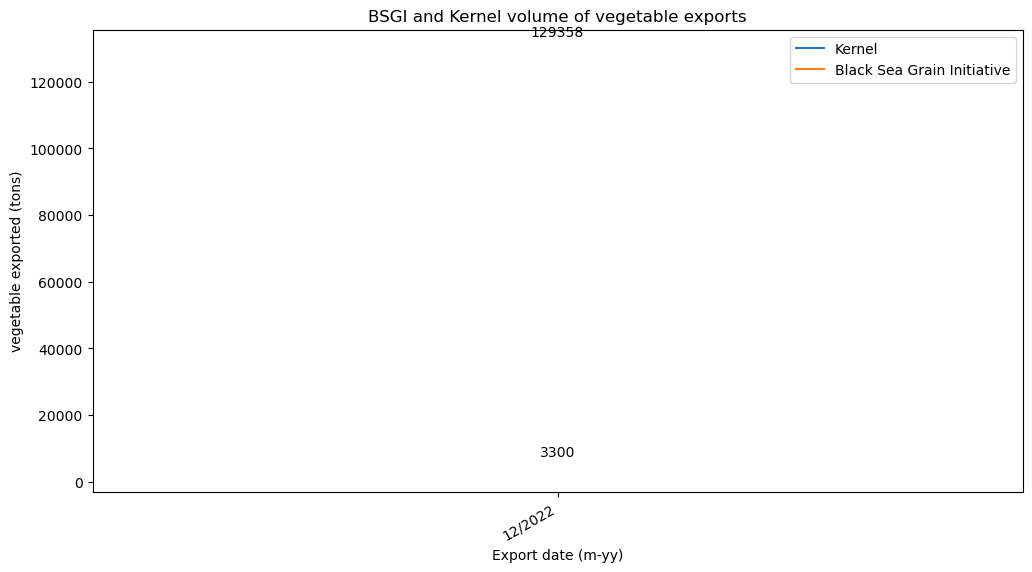

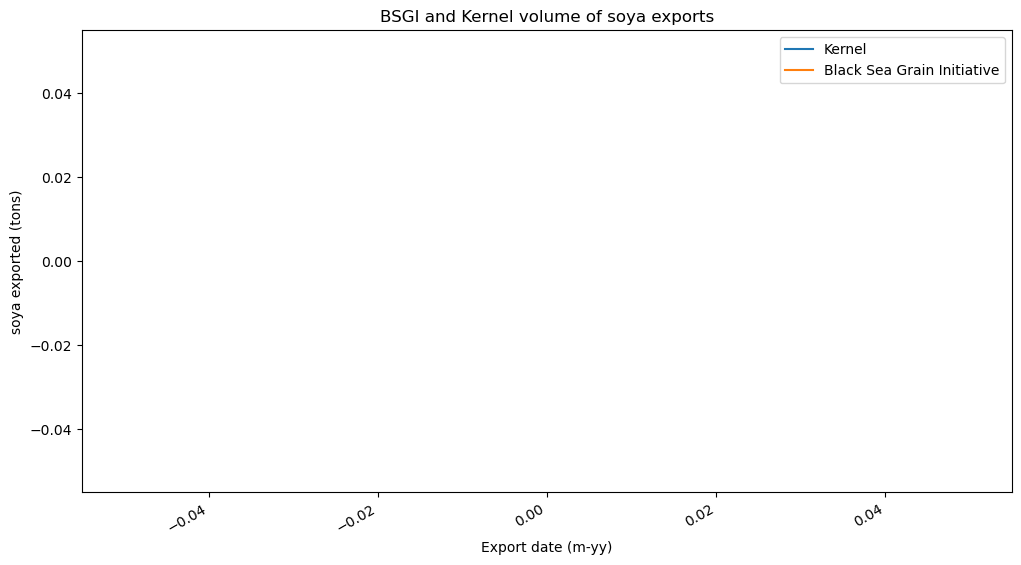

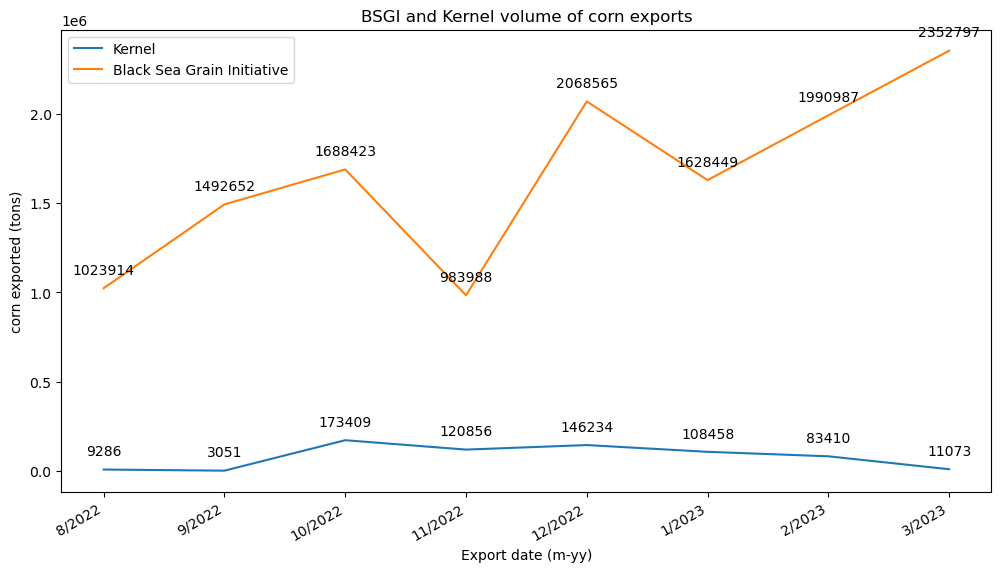

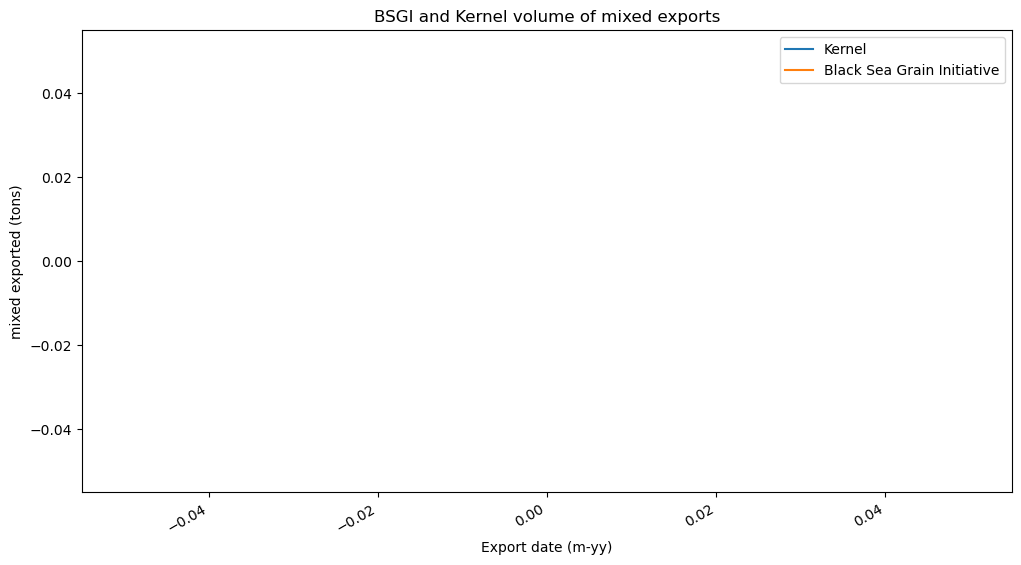

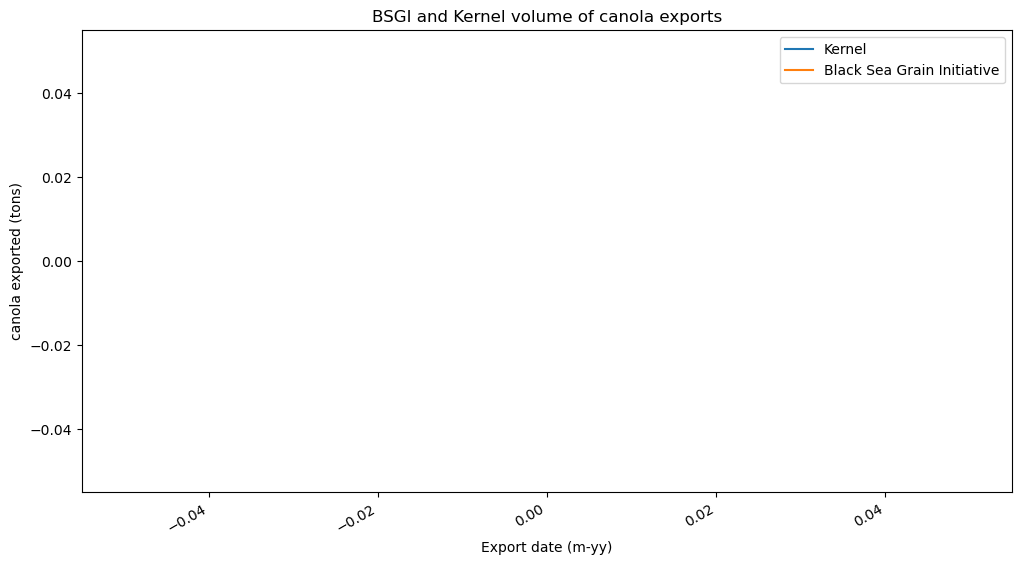

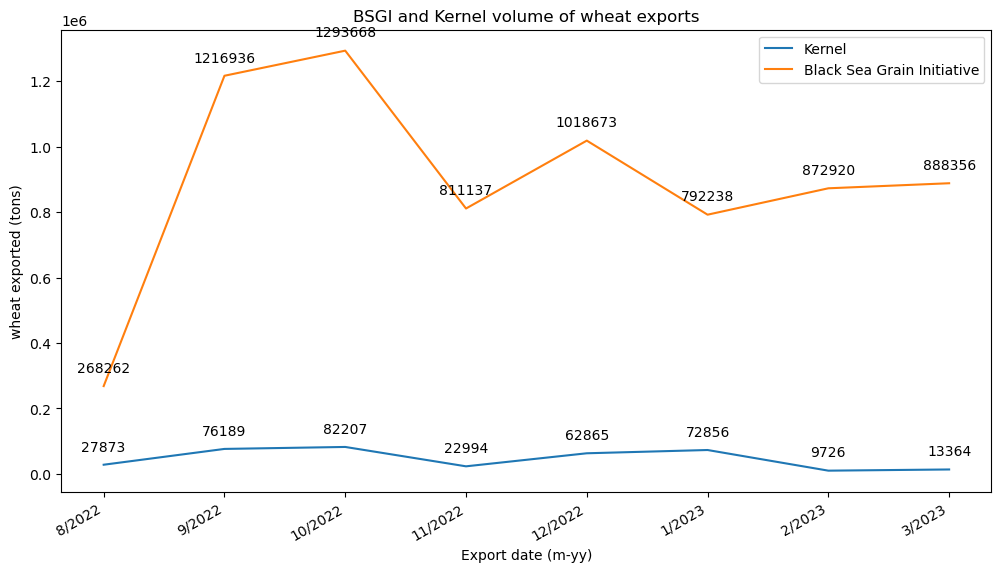

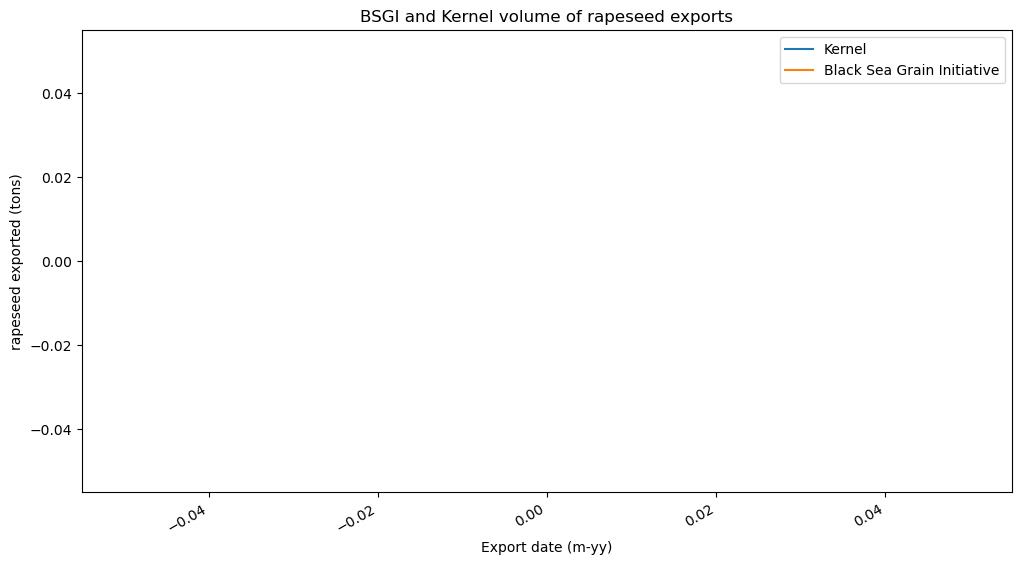

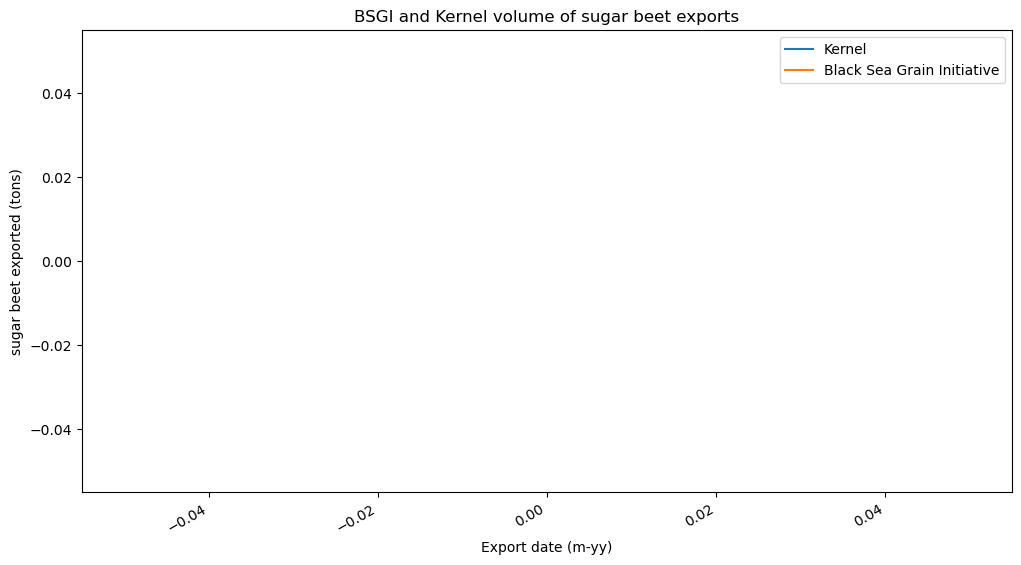

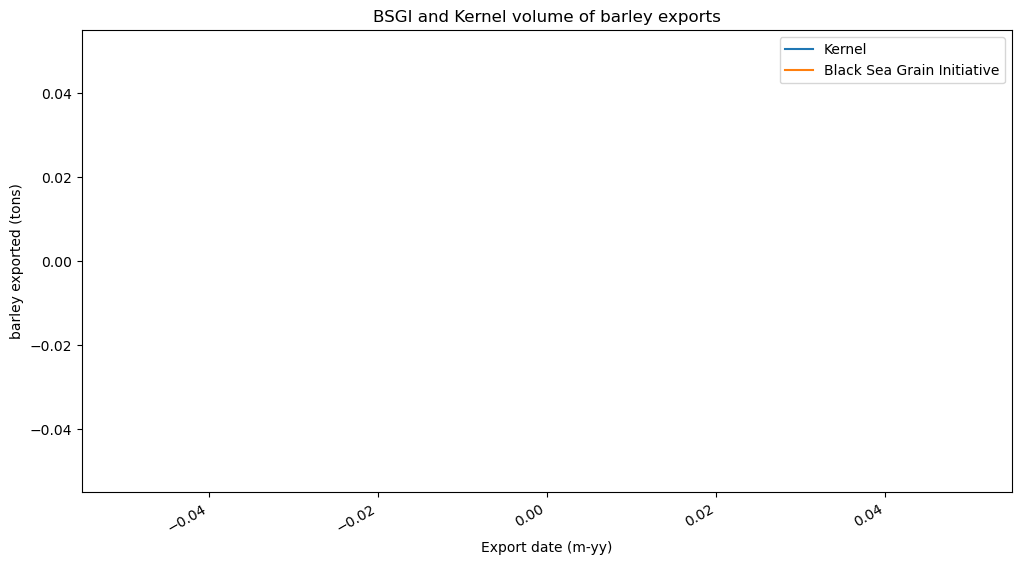

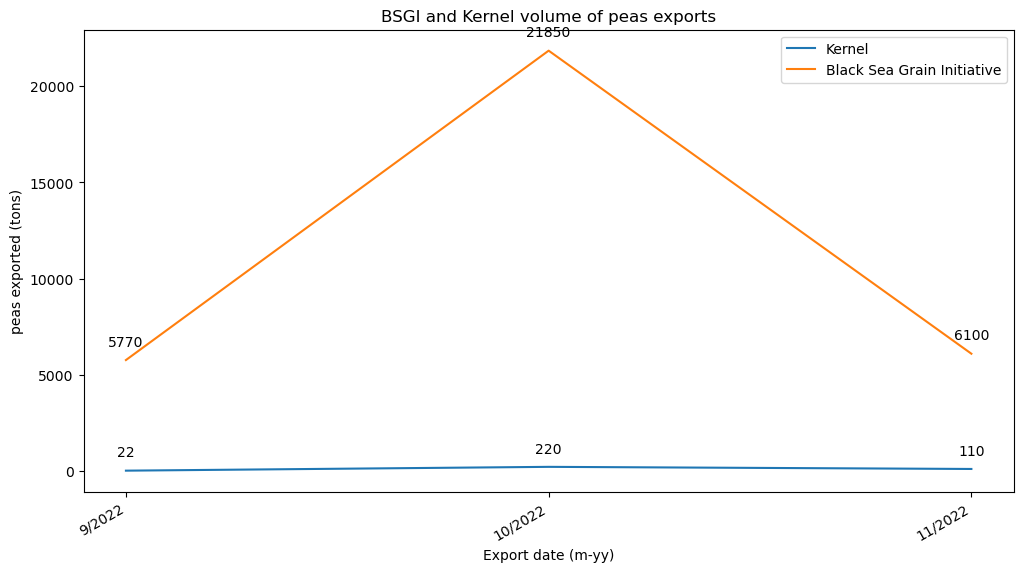

In [12]:
# PLOT CROPS

for crop in product_std:
    plot_crops(crop, kernel_c, outbound_c)

In [13]:
# RECORD MATCHING
print("Kernel:\n", kernel_c["DESTINATION COUNTRY"].head())
print("BSGI:\n", outbound_c["Country"].head())

# Translate country column to English
translate_column(kernel_c, "DESTINATION COUNTRY", "google", "uk", "en")
kernel_c["destination country_gt"] = kernel_c["destination country_gt"].str.lower()

Kernel:
 0       ОМАН
1       ОМАН
2     ІТАЛІЯ
3    СЕНЕГАЛ
4       ОМАН
Name: DESTINATION COUNTRY, dtype: object
BSGI:
 0     Spain
1    France
2     Italy
3     China
4     China
Name: Country, dtype: object


In [219]:
crop_kernel = kernel_c.loc[kernel_c.loc[:, "sunflower"] == True]
crop_bsgi = outbound_c.loc[outbound_c.loc[:, "product_std"] == "sunflower"]

crop_kernel = crop_kernel.rename(columns={"EXPORT DATE": "date", "destination country_gt": "country"})
crop_bsgi = crop_bsgi.rename(columns={"Departure date": "date", "Country": "country"})

crop_kernel.index.name = "kernel_i"
crop_bsgi.index.name = "bsgi_i"

matches = find_matches(crop_kernel, crop_bsgi, ["date"], ["country"], ["date"])
matches = matches.reset_index()[["kernel_i", "bsgi_i"]]
matches

Number of matches:  41


,kernel_i,bsgi_i
0,1157,447
1,1158,447
2,1600,573
3,1685,607
4,1687,607
5,1688,607
6,1689,607
7,1690,607
8,1786,638
9,1787,638


In [223]:
print("Import Genius:\n", crop_kernel.loc[[1863, 1865], ["date", "country", "product_deepl", "weight_ton"]])
print("BSGI:\n", crop_bsgi.loc[639, ["date", "country", "Commodity", "Metric tons"]])

Import Genius:
                date  country  \
kernel_i                       
1863     2022-11-04  romania   
1865     2022-11-04  romania   

                                              product_deepl  weight_ton  
kernel_i                                                                 
1863      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...     19.8720  
1865      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...     19.8720  
BSGI:
 date           2022-11-04 00:00:00
country                    romania
Commodity            Sunflower oil
Metric tons                  12500
Name: 639, dtype: object


In [221]:
# Now we try merging just exports from Import Genius that only have sunflower in their product name
# First we create a variable that sums the number of products mentioned in the product name
sunflower_kernel = kernel_c.copy()

sunflower_kernel["n_products"] = 0

for product in product_std:
    sunflower_kernel["n_products"] += sunflower_kernel[product]

# print("Products BSGI:\n", product_std)

sunflower_kernel = sunflower_kernel.loc[(sunflower_kernel.loc[:, "sunflower"] == True) & (sunflower_kernel.loc[:, "n_products"] == 1)]
sunflower_bsgi = outbound_c.loc[outbound_c.loc[:, "product_std"] == "sunflower"]

sunflower_kernel = sunflower_kernel.rename(columns={"EXPORT DATE": "date", "destination country_gt": "country"})
sunflower_bsgi = sunflower_bsgi.rename(columns={"Departure date": "date", "Country": "country"})

sunflower_kernel.index.name = "df1_i"
sunflower_bsgi.index.name = "df2_i"

matches = find_matches(sunflower_kernel, sunflower_bsgi, ["date"], ["country"], ["date"])

# Add this to find_matches function later if it turns out to be neccesary 
matches = matches.reset_index()
# print("All matches:\n", matches)
bsgi_i = matches.groupby("df2_i")["df1_i"].nunique()
unique = matches[matches["df2_i"].isin(bsgi_i[bsgi_i == 1].index)][["df1_i", "df2_i"]].reset_index(drop=True)

full_unique = unique.merge(sunflower_kernel, left_on='df1_i', right_index=True)
full_unique = full_unique.merge(sunflower_bsgi, left_on='df2_i', right_index=True)
full_unique[["df1_i", "df2_i", "date_x", "date_y", "product_deepl", "Commodity", "country_x" , "country_y", "weight_ton_x", "weight_ton_y"]]

Number of matches:  39


,df1_i,df2_i,date_x,date_y,product_deepl,Commodity,country_x,country_y,weight_ton_x,weight_ton_y
0,1600,573,2022-11-23,2022-11-23,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower seed,france,france,19.8720,40771
1,2012,683,2022-10-25,2022-10-25,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower oil,spain,spain,6300.0000,6300
2,2439,852,2022-09-28,2022-09-28,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower meal,italy,italy,20.0192,5350
3,2538,929,2022-09-19,2022-09-19,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower meal,italy,italy,19.4304,4400
4,2585,961,2022-09-15,2022-09-15,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower oil,italy,italy,20.0192,5750
5,2695,1022,2022-09-06,2022-09-06,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower oil,italy,italy,20.0192,5800


In [222]:
sunflower_kernel = kernel_c.copy()

sunflower_kernel["n_products"] = 0

for product in product_std:
    sunflower_kernel["n_products"] += sunflower_kernel[product]

# print("Products BSGI:\n", product_std)

sunflower_kernel = sunflower_kernel.loc[(sunflower_kernel.loc[:, "sunflower"] == True) & (sunflower_kernel.loc[:, "n_products"] == 1)]
sunflower_bsgi = outbound_c.loc[outbound_c.loc[:, "product_std"] == "sunflower"]

sunflower_kernel = sunflower_kernel.rename(columns={"EXPORT DATE": "date", "destination country_gt": "country"})
sunflower_bsgi = sunflower_bsgi.rename(columns={"Departure date": "date", "Country": "country"})

sunflower_kernel = sunflower_kernel[["date", "country", "weight_ton"]].groupby(["date", "country"]).sum().reset_index()

sunflower_kernel.index.name = "df1_i"
sunflower_bsgi.index.name = "df2_i"

matches = find_matches(sunflower_kernel, sunflower_bsgi, ["date"], ["country"], ["date"])

# Add this to find_matches function later if it turns out to be neccesary 
matches = matches.reset_index()
# print("All matches:\n", matches)
bsgi_i = matches.groupby("df2_i")["df1_i"].nunique()
unique = matches[matches["df2_i"].isin(bsgi_i[bsgi_i == 1].index)][["df1_i", "df2_i"]].reset_index(drop=True)

full_unique = unique.merge(sunflower_kernel, left_on='df1_i', right_index=True)
full_unique = full_unique.merge(sunflower_bsgi, left_on='df2_i', right_index=True)
full_unique[["df1_i", "df2_i", "date_x", "date_y", "Commodity", "country_x" , "country_y", "weight_ton_x", "weight_ton_y"]]

Number of matches:  12


,df1_i,df2_i,date_x,date_y,Commodity,country_x,country_y,weight_ton_x,weight_ton_y
0,1863,1046,2022-09-02,2022-09-02,Sunflower oil,india,india,19000.0000,21000
1,1875,1022,2022-09-06,2022-09-06,Sunflower oil,italy,italy,20.0192,5800
2,1912,961,2022-09-15,2022-09-15,Sunflower oil,italy,italy,20.0192,5750
3,1930,929,2022-09-19,2022-09-19,Sunflower meal,italy,italy,19.4304,4400
4,1948,895,2022-09-23,2022-09-23,Sunflower oil,romania,romania,5723.3380,11950
5,1963,852,2022-09-28,2022-09-28,Sunflower meal,italy,italy,20.0192,5350
6,2069,686,2022-10-25,2022-10-25,Sunflower oil,romania,romania,59.6160,4000
7,2071,683,2022-10-25,2022-10-25,Sunflower oil,spain,spain,6300.0000,6300
8,2105,639,2022-11-04,2022-11-04,Sunflower oil,romania,romania,39.7440,12500
9,2141,607,2022-11-15,2022-11-15,Sunflower meal,china,china,39350.0000,43000
